In [121]:
import nibabel as nib
import nilearn
from nilearn import plotting, image
import nideconv
from nideconv.utils import roi
import nighres
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import os
import seaborn as sns
from copy import deepcopy

%matplotlib inline

## Extract timeseries of M1

Masks are the "brainnettome" masks of the 'upper limb area' of M1. They're much more focal than the Harvard-Oxford M1 atlasses

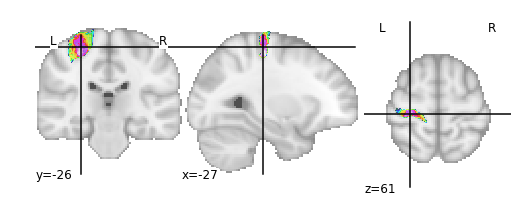

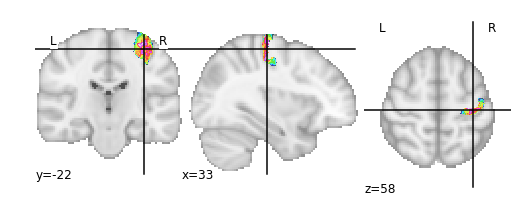

In [122]:
mask_lM1 = nib.load('masks/space-MNI152NLin2009cAsym_label-lM1_probseg.nii.gz')
mask_rM1 = nib.load('masks/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz')
plotting.plot_roi(mask_lM1)
plotting.plot_roi(mask_rM1)

array([[   1.5,    0. ,    0. ,  -96. ],
       [   0. ,    1.5,    0. , -132. ],
       [   0. ,    0. ,    1.5,  -78. ],
       [   0. ,    0. ,    0. ,    1. ]])

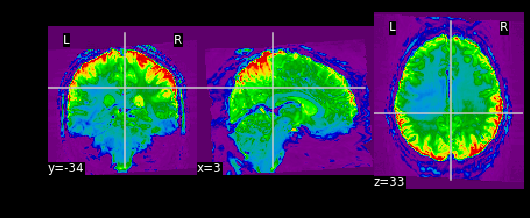

In [123]:
# to 1p5mm epi-space
epi = './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_boldref.nii.gz'
plotting.plot_epi(epi)
nib.load(epi).affine

In [124]:
mask_lM1_path = 'masks/space-MNI152NLin2009cAsym_label-lM1_probseg.nii.gz'
mask_rM1_path = 'masks/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz'

In [125]:
res = nighres.registration.embedded_antsreg(source_image=mask_lM1_path, 
                                            target_image=epi, 
                                            run_rigid=False, run_affine=False, run_syn=False, 
                                            rigid_iterations=0,
                                            affine_iterations=0, 
                                            coarse_iterations=0, 
                                            fine_iterations=0, 
                                            medium_iterations=0, save_data=True)
rM1 = nighres.registration.apply_coordinate_mappings(image=mask_rM1_path, mapping1=res['mapping'])


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to masks/
skip computation (use existing results)

Apply coordinate mappings


10041
9786


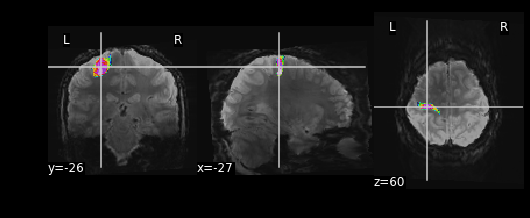

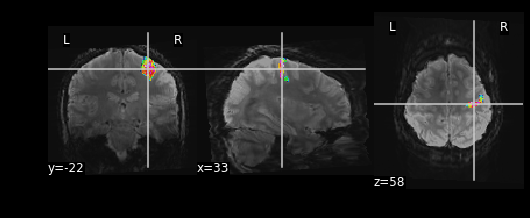

In [126]:
plotting.plot_roi(res['transformed_sources'][0], bg_img=epi)
plotting.plot_roi(rM1['result'], bg_img=epi)

print((res['transformed_sources'][0].get_data()>0).sum())
print((rM1['result'].get_data()>0).sum())

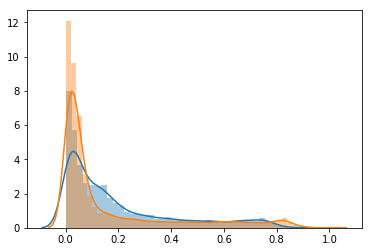

In [127]:
def make_distplot(nii):
    data = nii.get_data().ravel()
    data = data[data>0]
    sns.distplot(data)
    
make_distplot(rM1['result'])
make_distplot(res['transformed_sources'][0])

In [128]:
rm1 = deepcopy(rM1['result'])  #nib.load(mask_rM1_path) #.get_data() #rM1['result']
lm1 = deepcopy(res['transformed_sources'][0]) #res['transformed_source']

def threshold_(nii, value):
    data = nii.get_data()
    data[data < value] = 0
    return nib.Nifti1Image(data, affine=nii.affine)

print(sum(threshold_(rm1, 0.751426).get_data()>0).sum())
print(sum(threshold_(lm1, 0.8266).get_data()>0).sum())

200
200


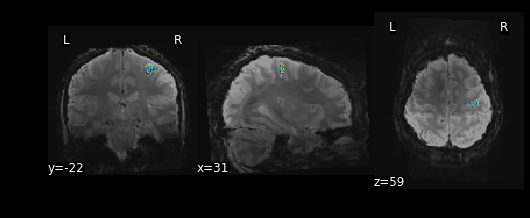

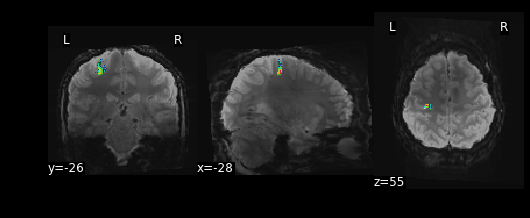

In [129]:
## threshold, get 200 most-likely voxels
rm1 = deepcopy(rM1['result'])  #nib.load(mask_rM1_path) #.get_data() #rM1['result']
lm1 = deepcopy(res['transformed_sources'][0]) #res['transformed_source']

def threshold_(nii, value):
    data = nii.get_data()
    data[data < value] = 0
    return nib.Nifti1Image(data, affine=nii.affine)

rm1_thresholded = threshold_(rm1, 0.751426)
lm1_thresholded = threshold_(lm1, 0.8266)
print(sum(rm1_thresholded.get_data()>0).sum())
print(sum(lm1_thresholded.get_data()>0).sum())

plotting.plot_roi(rm1_thresholded, bg_img=epi, draw_cross=False)
plotting.plot_roi(lm1_thresholded, bg_img=epi, draw_cross=False)

nib.save(rm1_thresholded, filename='masks/space-MNI152NLin2009cAsym-1p5mm_label-rM1_probseg.nii.gz')
nib.save(lm1_thresholded, filename='masks/space-MNI152NLin2009cAsym-1p5mm_label-lM1_probseg.nii.gz')

### extract timeseries from epis

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: 

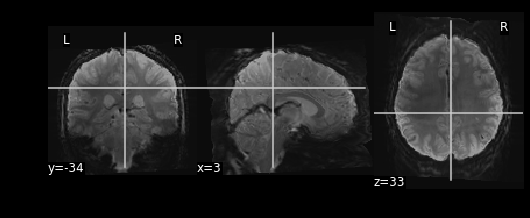

In [50]:
from sklearn.utils import Bunch
M1_atlas = Bunch(labels=['rM1', 'lM1'], 
                 maps=nilearn.image.concat_imgs(['./masks/space-MNI152NLin2009cAsym-1p5mm_label-rM1_probseg.nii.gz',
                                                 './masks/space-MNI152NLin2009cAsym-1p5mm_label-lM1_probseg.nii.gz']))
plotting.plot_prob_atlas(M1_atlas.maps, bg_img=epi)

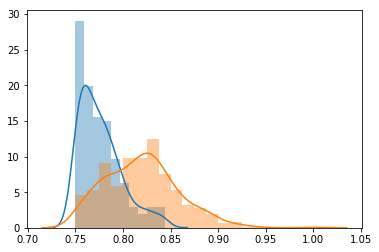

In [57]:
make_distplot(image.index_img(M1_atlas.maps, 0))
make_distplot(image.index_img(M1_atlas.maps, 1))

In [58]:
fns = glob.glob('./derivatives/ds-*/fmriprep/sub-*/func/sub-*_task-randomdotmotion_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
reg = re.compile('.*/ds-(?P<ds>[\d]+)/fmriprep/sub-(?P<sub>[\d]+)/func/.*_run-(?P<run>[\d]+)_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
sorted(fns)

<>:2: DeprecationWarning: invalid escape sequence \d


['./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-02_space

In [61]:
to_run = fns
def do_extract(fn, reg, M1_atlas):
    if reg.match(fn) is None:
        print('fn {} is None, skipping'.format(fn))
        return 0
    
    ds = reg.match(fn).groupdict()['ds']
    sub = reg.match(fn).groupdict()['sub']
    run = reg.match(fn).groupdict()['run']
    output_fn = '/home/stevenm/bias/extracted_signals/ds-{}/sub-{}_run-{}.csv'.format(ds, sub, run)
    brain_mask = '/home/stevenm/bias/derivatives/ds-{}/fmriprep/sub-{}/func/sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2), str(run).zfill(2))
    nii_fn = os.path.join('/home/stevenm/bias', fn)  # absolute path just to be sure
#     if os.path.exists(output_fn):
#         return 0
    
    print('Running {}'.format(reg.match(fn).groupdict()))
    print(output_fn)
    print(nii_fn)
    ts = roi.extract_timecourse_from_nii(M1_atlas,
                                         nii_fn,
                                         confounds=None,
                                         mask=brain_mask,
                                         t_r=3,
                                         high_pass=None)
    
    ts.to_csv(output_fn)
    return 0


In [62]:
import multiprocessing as mp
from functools import partial

with mp.Pool(30) as p:
    p.map(partial(do_extract, M1_atlas=M1_atlas, reg=reg), to_run)

Running {'ds': '02', 'sub': '14', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-14_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '14', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-02/sub-14_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '14', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-14_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '09', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-09_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-prep

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '02', 'sub': '06', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-06_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '06', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-06_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


fn ./derivatives/ds-02/fmriprep/sub-02.nob0/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz is None, skipping
fn ./derivatives/ds-02/fmriprep/sub-02.nob0/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz is None, skipping
fn ./derivatives/ds-02/fmriprep/sub-02.nob0/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz is None, skipping
Running {'ds': '02', 'sub': '03', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-02/sub-03_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '03', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-03_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '02', 'sub': '03', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-03_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '02', 'sub': '02', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '02', 'sub': '02', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '02', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '02', 'sub': '11', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-02/sub-11_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '11', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-11_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '11', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-11_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '14', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-14_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '14', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-14_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '14', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-14_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '09', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-09_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '09', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-09_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-prep

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '09', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-09_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '08', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-08_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '08', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-08_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '08', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-08_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '19', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-19_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '19', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-19_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '19', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-19_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '12', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-12_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '12', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-12_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '12', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-12_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '01', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-01_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '01', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-01_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '01', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-01_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '16', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-16_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '16', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-16_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '16', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-16_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '13', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-13_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a

Running {'ds': '01', 'sub': '13', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-13_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '13', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-13_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '05', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-05_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '05', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-05_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a

Running {'ds': '01', 'sub': '05', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-05_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '10', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-10_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

Running {'ds': '01', 'sub': '10', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-10_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a

Running {'ds': '01', 'sub': '10', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-10_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '04', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-04_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-04/func/sub-04_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '04', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-04_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-04/func/sub-04_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '04', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-04_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-04/func/sub-04_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '07', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-07_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '07', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-07_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '07', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-07_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '15', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-15_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '15', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-15_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '15', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-15_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

Running {'ds': '01', 'sub': '17', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-17_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '17', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-17_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and wi

Running {'ds': '01', 'sub': '17', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-17_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '18', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-18_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '18', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-18_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '18', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-18_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '06', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-06_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '06', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-06_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '03', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-03_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '01', 'sub': '03', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-03_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '03', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-03_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '02', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-02_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '02', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-02_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '02', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-02_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memo

Running {'ds': '01', 'sub': '11', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-01/sub-11_run-02.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


Running {'ds': '01', 'sub': '11', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-01/sub-11_run-01.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Running {'ds': '01', 'sub': '11', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-01/sub-11_run-03.csv
/home/stevenm/bias/./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and wi

In [12]:
# for fn in fns:
#     do_extract(fn, reg=reg, M1_atlas=M1_atlas)